In [ ]:
# -----------------------------------------------
# 1) INSTALL AND IMPORT DEPENDENCIES
# -----------------------------------------------

!pip install --upgrade tensorflow==2.19.0

!pip install -q tensorflow_decision_forests
# For text preprocessing
# !pip install -q spacy
# !python -m spacy download en_core_web_sm

import numpy as np
import pandas as pd
import re, nltk, spacy

# NLTK downloads
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

# Load spaCy model
nlp = spacy.load("en_core_web_sm")

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# TensorFlow and TF Decision Forests
import tensorflow as tf
import tensorflow_decision_forests as tfdf

# Check library versions
print("TensorFlow version:", tf.__version__)
print("TF-DF version:", tfdf.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 50.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.18.0
    Uninstalling tensorboard-2.18.0:
      Successfully uninstalled tensorboard-2.18.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.18.0
    Uninstalling tensorflow-2.18.0:
      Successfully uninstalled tensorflow-2.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


TensorFlow version: 2.18.0
TF-DF version: 1.11.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# -----------------------------------------------
# 2) LOAD AND PREVIEW YOUR DATA
# -----------------------------------------------

# Example: if the file is in your Colab environment:

df = pd.read_csv("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/cleaned_reddit_comments_NEW.csv")
# df = df[['comment', 'label']]  # Ensure columns match exactly

df["comment"] = df["comment"].str.lower()
df
# print("\nLabel distribution:")
# print(df['label'].value_counts())


,label,comment
0,0,nc and nh
1,0,you do know west team play against west team m...
2,0,they be underdogs early today but since gronk ...
3,0,this meme be not funny none new york nigga one be
4,0,i could use one those tool
...,...,...
1010821,1,i sure that iran and n. korea have technology ...
1010822,1,whatever you do do not vote green
1010823,1,perhaps this be atheist conspiracy to make chr...
1010824,1,slavs get their own country it be call kosovo


In [ ]:
from sklearn.model_selection import train_test_split

strat = df['label']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42, stratify= strat)
strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42, stratify= strat)
print('Total dataset is ', df.shape)
print('Train shape is ' , train_df.shape)
print('Valid shape is ' , valid_df.shape)
print('Test shape is ' , test_df.shape)


Total dataset is  (1010826, 2)
Train shape is  (808660, 2)
Valid shape is  (101083, 2)
Test shape is  (101083, 2)


In [ ]:
test_df = pd.concat([test_df, valid_df], ignore_index=True)
test_df

,label,comment
0,0,hey it be just matter time before someone broo...
1,0,but lulu be already 1350 skin skins sale be 97...
2,0,it be tricky than i think
3,1,they keep shoot themselves because we need mor...
4,0,maybe that be why his colon try to kill he rev...
...,...,...
202161,0,catcher have mini panic attack thinking fuck d...
202162,0,i be so sad when he and katy perry break up
202163,1,thank national medium for hype this up so much...
202164,0,it be not like i have not have diarrhea for ho...


# Building N-gram Dictionary

The N-gram dictionary is created using the training dataset only. It is saved into the Drive to avoid having to create it again.

Run time to create train features: 1 hr 48 mins



4/18/25
Note: fixed this cell to work on news headlines dataset

In [ ]:
from collections import defaultdict, Counter
import pickle

def build_ngram_probability_dict(df, threshold=3):
    sarcastic_counts = Counter()
    nonsarcastic_counts = Counter()

    sarcastic_total = 0
    nonsarcastic_total = 0

    for _, row in df.iterrows():
        label = row['label']
        text = str(row['comment']).lower()
        doc = nlp(text)
        tokens = [token.text for token in doc if not token.is_space]

        # Unigrams and bigrams
        unigrams = tokens
        bigrams = [" ".join(pair) for pair in zip(tokens, tokens[1:])]
        all_ngrams = unigrams + bigrams

        if label == 1:  # sarcastic
            sarcastic_total += 1
            sarcastic_counts.update(all_ngrams)
        else:
            nonsarcastic_total += 1
            nonsarcastic_counts.update(all_ngrams)

    # Now build probability dictionary
    ngram_dict = {}
    all_ngrams = set(sarcastic_counts) | set(nonsarcastic_counts)

    for ngram in all_ngrams:
        s_count = sarcastic_counts[ngram]
        ns_count = nonsarcastic_counts[ngram]

        # Only include if s_count or ns_count meets threshold
        if s_count >= threshold or ns_count >= threshold:
            ps = s_count / (s_count + ns_count)
            pns = ns_count / (s_count + ns_count)

            ngram_dict[ngram] = (ps, pns)

    return ngram_dict

# save_path = ""
# with open(save_path, 'wb') as handle:
#     pickle.dump(ngram_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


# Feature Extraction
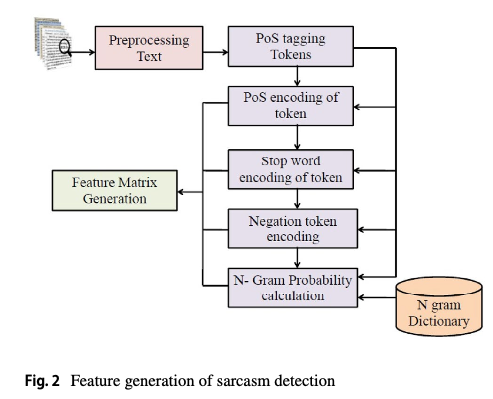

In [ ]:
import pickle
dict_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/ngram_dict_apr6.pickle"
with open(dict_path, 'rb') as f:
    ngram_dict = pickle.load(f)

In [ ]:
import numpy as np
import spacy
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences
from google.colab import drive

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

# POS tag mapping
POS_TAGS = {
    "NOUN": 0, "PRON": 1, "VERB": 2, "ADV": 3, "ADJ": 4,
    "DET": 5, "CCONJ": 6, "AUX": 7, "PART": 8
}

# Custom vocab sets
custom_stopwords = {"am", "the", "from", "on", "in", "at", "of", "a", "an"}
negation_words = {"not", "no", "never", "n't", "nothing", "none"}
interjections = {"wow", "yay", "oops", "oh", "ugh", "ah", "eh"}

# Load your precomputed ngram_dict

def get_ngram_probs(token, prev_token, next_token):
    if next_token:
        forward = f"{token} {next_token}"
        if forward in ngram_dict:
            return ngram_dict[forward]
    if prev_token:
        backward = f"{prev_token} {token}"
        if backward in ngram_dict:
            return ngram_dict[backward]
    return ngram_dict.get(token, (0.5, 0.5))

def extract_15_features_per_token(text):
    doc = nlp(text.lower())
    tokens = [token for token in doc if not token.is_space]
    feature_matrix = []

    for i, token in enumerate(tokens):
        vec = np.zeros(15, dtype=np.float32)

        # POS one-hot (first 9)
        if token.pos_ in POS_TAGS:
            vec[POS_TAGS[token.pos_]] = 1

        # Stopword flag
        vec[9] = 1 if token.text in custom_stopwords else 0

        # Negation flag
        vec[10] = 1 if token.text in negation_words else 0

        # Punctuation follows
        if i < len(tokens) - 1 and tokens[i+1].text in {"!", "?"}:
            vec[11] = 1

        # Interjection flag
        vec[12] = 1 if token.text in interjections else 0

        # N-gram Ps/Pns
        prev_token = tokens[i - 1].text if i > 0 else None
        next_token = tokens[i + 1].text if i < len(tokens) - 1 else None
        ps, pns = get_ngram_probs(token.text, prev_token, next_token)
        vec[13] = ps
        vec[14] = pns

        feature_matrix.append(vec)

    return np.array(feature_matrix)


Training set

In [ ]:
# Double-check variables
print(len(ngram_dict))
print(train_df.shape)

235839
(808660, 2)


In [ ]:
# Dataset → 3D feature tensor
MAX_LEN = 50  # pad all to this length
X = []
y = []

for _, row in train_df.iterrows():
    comment = str(row['comment'])
    label = row['label']

    token_features = extract_15_features_per_token(comment)
    padded = pad_sequences([token_features], maxlen=MAX_LEN, padding='post', dtype='float32', truncating='post')[0]

    X.append(padded)
    y.append(label)

X = np.array(X)
y = np.array(y)

# Save as pickle
save_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/15d_feature_matrix_train_Apr18.pkl"
with open(save_path, 'wb') as f:
    pickle.dump((X, y), f, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved 15-dim token-level feature matrix to:")
print(save_path)

X_train = X
y_train = y


Saved 15-dim token-level feature matrix to:
/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/15d_feature_matrix_train_Apr18.pkl


Test set

In [ ]:
# Dataset → 3D feature tensor
# 25 minutes
MAX_LEN = 50  # pad all to this length
X = []
y = []

for _, row in test_df.iterrows():
    comment = str(row['comment'])
    label = row['label']

    token_features = extract_15_features_per_token(comment)
    padded = pad_sequences([token_features], maxlen=MAX_LEN, padding='post', dtype='float32', truncating='post')[0]

    X.append(padded)
    y.append(label)

X = np.array(X)
y = np.array(y)

# Save as pickle
save_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/15d_feature_matrix_test_Apr18.pkl"
with open(save_path, 'wb') as f:
    pickle.dump((X, y), f, protocol=pickle.HIGHEST_PROTOCOL)

print("Saved 15-dim token-level feature matrix to:")
print(save_path)


Saved 15-dim token-level feature matrix to:
/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/15d_feature_matrix_test_Apr18.pkl


# Training

In [ ]:
# Load updated padded & flattened (X, y) for train and test
import pickle
with open("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/15d_feature_matrix_train_Apr18.pkl", 'rb') as f:
    X_train, y_train = pickle.load(f)

with open("/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/15d_feature_matrix_test_Apr18.pkl", 'rb') as f:
    X_test, y_test = pickle.load(f)
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))

Analyzing sample (for debug)

In [ ]:
# First comment (sample)
for _, row in train_df.iterrows():
  print(row)
  break

label                     0
comment    central illinois
Name: 928042, dtype: object


POS_TAGS = {"NOUN": 0, "PRON": 1, "VERB": 2, "ADV": 3, "ADJ": 4,"DET": 5, "CCONJ": 6, "AUX": 7, "PART": 8}

central = ADJ **[4]**, illinois = NOUN **[0]**

In [ ]:
ngram_dict["illinois"]

(0.5340909090909091, 0.4659090909090909)

In [ ]:
# comment: "central illinois"
# POS (9) -> stopword (1) -> negation (1) -> punctuation follows (1) -> interjection (1) -> ngram (2)

# # Custom vocab sets
# custom_stopwords = {"am", "the", "from", "on", "in", "at", "of", "a", "an"}
# negation_words = {"not", "no", "never", "n't", "nothing", "none"}
# interjections = {"wow", "yay", "oops", "oh", "ugh", "ah", "eh"}

X_train[0]

array([[0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.41304347, 0.5869565 ],
       [1.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.53409094, 0.4659091 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 

In [ ]:
# -----------------------------------------------
# BUILD AND TRAIN TF-DF RANDOM FOREST
# -----------------------------------------------
# rf_model = tfdf.keras.RandomForestModel(
#     task=tfdf.keras.Task.CLASSIFICATION,
#     num_trees=200,
#     max_depth=10,
#     random_seed=42,
#     verbose=1
# )
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,         # More trees = better stability
    max_depth=10,             # Prevent overfitting on short feature vectors
    min_samples_split=5,      # Be a bit stricter about splitting
    min_samples_leaf=3,       # Helps with generalization
    class_weight='balanced',  # Useful if your sarcasm classes are imbalanced
    random_state=42,          # Reproducibility
    n_jobs=-1,                 # Use all CPU cores
    verbose=1
)



In [ ]:
# First comment (sample)
for _, row in test_df.iterrows():
  print(row.comment)
  print("Sarcastic? ", row.label)
  break

hey it be just matter time before someone brooklyn get their ph.d
Sarcastic?  0


In [ ]:
ngram_dict["it be"]

(0.5135721858539622, 0.48642781414603775)

POS_TAGS = {"NOUN": 0, "PRON": 1, "VERB": 2, "ADV": 3, "ADJ": 4,"DET": 5, "CCONJ": 6, "AUX": 7, "PART": 8}

In [ ]:
X_test[0]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.71497583, 0.28502417],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.51357216, 0.4864278 ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.6200717 , 0.37992832],
       [0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.44      , 0.56      ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 

In [ ]:
# Convert tf.Dataset back to NumPy for sklearn
# X_train_np = np.vstack([x.numpy() for x, _ in train_ds])
# y_train_np = np.concatenate([y.numpy() for _, y in train_ds])

rf_model.fit(X_train_flat, y_train)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 32.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 32.7min finished


RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_leaf=3, min_samples_split=5,
                       n_estimators=200, n_jobs=-1, random_state=42, verbose=1)

In [ ]:
import pickle

model_path = "/content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/random_forest_model_Apr19.pkl"

with open(model_path, 'wb') as f:
    pickle.dump(rf_model, f)

print("Model saved to:", model_path)


Model saved to: /content/drive/My Drive/Kaggle Club/SARCASM PROJECT '25/random_forest_model_Apr19.pkl


In [ ]:

print("\nTest Accuracy:", rf_model.score(X_test_flat, y_test))


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.5s



Test Accuracy: 0.7088926921440796


[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    6.3s finished


In [ ]:
# # USE FOR TENSORFLOW MODELS ONLY

# eval_result = rf_model.evaluate(val_ds, return_dict=True)
# print("\nValidation Accuracy:", eval_result["accuracy"])

# test_result = rf_model.evaluate(test_ds, return_dict=True)
# print("Test Accuracy:", test_result["accuracy"])

# rf_model.summary()

In [ ]:
# # -----------------------------------------------
# # 8) MODEL EVALUATION
# # -----------------------------------------------

# y_pred_probs = rf_model.predict(test_ds)
# # For a binary classification, shape is (N, 2) => we argmax over axis=1
# y_pred = np.argmax(y_pred_probs, axis=1)

# acc = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", acc)


In [ ]:
from sklearn.metrics import classification_report

# Predict on the test set
y_pred = rf_model.predict(X_test_flat)

# Print the classification report
print(classification_report(y_test, y_pred, digits=4))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   12.4s


              precision    recall  f1-score   support

           0     0.6937    0.7480    0.7199    101083
           1     0.7266    0.6698    0.6970    101083

    accuracy                         0.7089    202166
   macro avg     0.7102    0.7089    0.7084    202166
weighted avg     0.7102    0.7089    0.7084    202166



[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:   12.8s finished


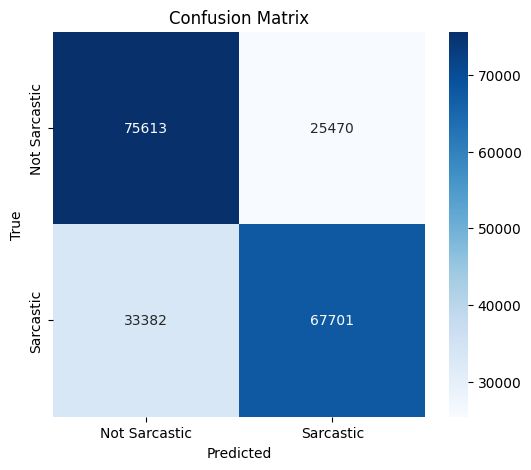

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Step 2: Get true labels from the test dataset
# If test_ds was built from numpy arrays
# y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_test, y_pred)

# Step 4: Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Sarcastic', 'Sarcastic'], yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()
